# CutMix Augmentation for Image Classification

**Author:** [Sayan Nath](https://twitter.com/SayanNa20204009)<br>
**Date created:** 2021/03/25<br>
**Last modified:** 2021/03/25<br>
**Description:** Data augmentation using the CutMix technique for image classification.

## Introduction

_CutMix_ is a data augmentation technique proposed in [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
by Sangdoo Yun, Dongyoon Han, Seong Joon Oh, Sanghyuk Chun,
Junsuk Choe, Youngjoon Yoo. 

In CutMix Augmentation technique,instead of removing pixels and filling them with black or grey pixels or Gaussian noise a patch of similar dimension is placed from another image. 

The ground truth labels are mixed proportionally to the number of pixels of combined images. The labels which are linearly iinterpolated label which gets produced is proportional to the pixels which are contributing from the two images. 

CutMix Augmentation is used when there is presence of uninformative pixel during training.

It's implemented with the following formulas:

<img height=100 width=250 src="https://raw.githubusercontent.com/sayannath/CutMix-Augmentation---Keras/main/assets/cutmix-1.png?token=AKAF55CUC3LRB4YI7RXCO3TAMXKHU">

<!-- ![](https://raw.githubusercontent.com/sayannath/CutMix-Augmentation---Keras/main/assets/cutmix-1.png?token=AKAF55CUC3LRB4YI7RXCO3TAMXKHU) -->

where M is the binary mask which indicates the cutout and the fill-in regions from the two randomly drawn images and λ is drawn from [Beta(α,α) distribution](https://en.wikipedia.org/wiki/Beta_distribution) and `λ ∈ [0, 1]`


The coordinates of bounding boxes are <img height=40 width=150 src="https://raw.githubusercontent.com/sayannath/CutMix-Augmentation---Keras/main/assets/cutmix-3.png?token=AKAF55G3SW73WB34GD74ARDAMXKCA"> which indicates the cutout and fill-in regions in case of the images.

The bounding box sampling is represented by:

<img height=100 width=250 src="https://raw.githubusercontent.com/sayannath/CutMix-Augmentation---Keras/main/assets/cutmix-2.png?token=AKAF55CDRYZPUHPXDVCGUODAMXKRS">

where `rx,ry` are randomly drawn from a uniform distribution with upper bound

This example requires TensorFlow 2.4 or higher.

## Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50
import tensorflow_probability as tfp

np.random.seed(42)
tf.random.set_seed(42)
tfd = tfp.distributions

%matplotlib inline

## Load the CIFAR10 dataset

For this example, we will be using the
[CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = pd.get_dummies(y_train.flatten()).values.astype(np.float32)
y_test = pd.get_dummies(y_test.flatten()).values.astype(np.float32)

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

## Define hyperparameters

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32

## Dataloader

In [5]:
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = tf.image.convert_image_dtype(image, tf.float32) / 255.
  return image, label

## Convert the data into TensorFlow `Dataset` objects

In [6]:
train_ds_one = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
train_ds_two = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# We will be combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (test_ds.map(preprocess_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

##Define the CutMix Technique Function

cutmix function takes two `image` and `label` pair and performs cutmix augmentation. It samples `λ(l)` from a [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution) and we get the bounding box from get_box function. We crop the image2 and pad this image in the final padded image at the same location. 

In [7]:
@tf.function
def get_box(l):
  cut_rat = tf.math.sqrt(1.-l)

  cut_w = IMG_SHAPE*cut_rat #rw
  cut_w = tf.cast(cut_w, tf.int32)
  
  cut_h = IMG_SHAPE*cut_rat #rh
  cut_h = tf.cast(cut_h, tf.int32)
  
  cx = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #rx
  cy = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #ry
  
  bbx1 = tf.clip_by_value(cx[0] - cut_w // 2, 0, IMG_SHAPE)
  bby1 = tf.clip_by_value(cy[0] - cut_h // 2, 0, IMG_SHAPE)
  bbx2 = tf.clip_by_value(cx[0] + cut_w // 2, 0, IMG_SHAPE)
  bby2 = tf.clip_by_value(cy[0] + cut_h // 2, 0, IMG_SHAPE)
  
  target_h = bby2-bby1
  if target_h ==0:
    target_h+=1

  target_w = bbx2-bbx1
  if target_w ==0:
    target_w+=1

  return bbx1, bby1, target_h, target_w

@tf.function
def cutmix(a, b):
  
  (image1, label1), (image2, label2) = a, b

  alpha = [1.]
  beta = [1.]
  
  ## Get sample from beta distribution
  dist = tfd.Beta(alpha, beta)
  ## Lambda
  l = dist.sample(1)[0][0]

  ## Get bbox ofsets and heights and widths
  bbx1, bby1, target_h, target_w = get_box(l)

  ## Get patch from image2
  crop2 = tf.image.crop_to_bounding_box(image2, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  image2 = tf.image.pad_to_bounding_box(crop2, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)
  ## Get patch from image1
  crop1 = tf.image.crop_to_bounding_box(image1, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  img1 = tf.image.pad_to_bounding_box(crop1, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)

  ## Subtract the patch from image1 so that patch from image2 can be put on instead
  image1 = image1-img1
  ## Add modified image1 and image2 to get cutmix image
  image = image1+image2

  ## Adjust lambda according to pixel ration
  l = 1 - (target_w * target_h) / (IMG_SHAPE * IMG_SHAPE)
  l = tf.cast(l, tf.float32)

  ## Combine labels
  label = l*label1+(1-l)*label2

  return image, label

**Note** that here , we are combining two images to create a single one.

## Visualize the new dataset after applying CutMix Augmentation.

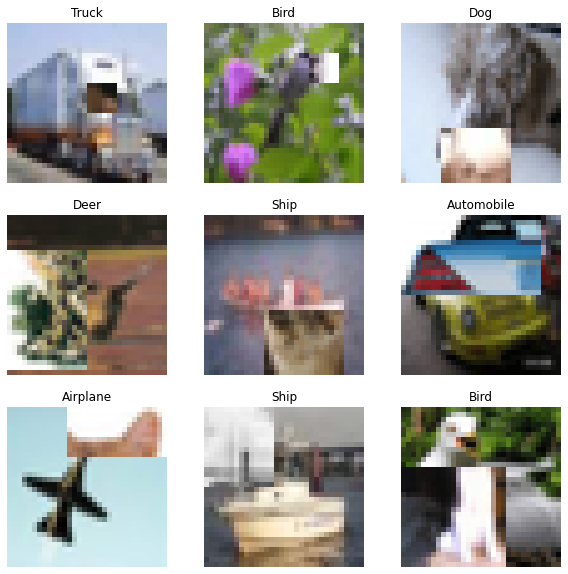

In [8]:
# Create the new dataset using our `mix_up` utility
train_ds_cmu = (train_ds.shuffle(1024).map(cutmix, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3 ,3 ,i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis('off')

## Define the Model

In [9]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = keras.layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v20(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = keras.layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def training_model():
  return resnet_v20((32,32,3), 20) 

In [11]:
initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

## 1. Train the model with the CutMix Dataset

In [13]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu,validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 71s 23ms/step - loss: 2.1305 - accuracy: 0.3221 - val_loss: 1.4408 - val_accuracy: 0.5543
Epoch 2/15
1563/1563 [==============================] - 37s 23ms/step - loss: 1.8168 - accuracy: 0.4817 - val_loss: 1.2450 - val_accuracy: 0.6202
Epoch 3/15
1563/1563 [==============================] - 37s 23ms/step - loss: 1.6970 - accuracy: 0.5403 - val_loss: 1.2158 - val_accuracy: 0.6273
Epoch 4/15
1563/1563 [==============================] - 37s 23ms/step - loss: 1.6330 - accuracy: 0.5694 - val_loss: 1.1203 - val_accuracy: 0.6656
Epoch 5/15
1563/1563 [==============================] - 37s 23ms/step - loss: 1.5900 - accuracy: 0.5933 - val_loss: 0.9935 - val_accuracy: 0.7254
Epoch 6/15
1563/1563 [==============================] - 37s 23ms/step - loss: 1.5560 - accuracy: 0.6103 - val_loss: 0.8896 - val_accuracy: 0.7597
Epoch 7/15
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5388 - accuracy: 0.6156 - val_loss: 1.0440 -

## 2. Train the model with the Original Dataset

In [14]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple,validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 23s 13ms/step - loss: 1.7219 - accuracy: 0.4337 - val_loss: 1.3146 - val_accuracy: 0.5816
Epoch 2/15
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1353 - accuracy: 0.6540 - val_loss: 1.5839 - val_accuracy: 0.5463
Epoch 3/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9312 - accuracy: 0.7312 - val_loss: 1.1482 - val_accuracy: 0.6785
Epoch 4/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8073 - accuracy: 0.7773 - val_loss: 1.0559 - val_accuracy: 0.7073
Epoch 5/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7283 - accuracy: 0.8094 - val_loss: 1.0752 - val_accuracy: 0.7103
Epoch 6/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6654 - accuracy: 0.8350 - val_loss: 1.2397 - val_accuracy: 0.6937
Epoch 7/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6182 - accuracy: 0.8550 - val_loss: 1.5660 -

## Notes

In this example, we trained our model for 15 epochs. On the CIFAR10 dataset, the model performs better with `CutMix Augmentation` with a better accuracy (for example 77.15% in one experiment) compared to model with a accuracy (for example 71.06%).

In the notebook, you may notice that, the time taken during the CutMix Augmentation.

You can also experiment this `CutMix` technique by reading this [Original Paper](https://arxiv.org/pdf/1905.04899.pdf)